In [72]:
import numpy as np
import pandas as pd

from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cirrhosis = pd.read_csv('cirrhosis.csv', header=0, sep=',')
cirrhosis.head(20)

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
5,6,2503,D,Placebo,24201,F,N,Y,N,N,0.8,248.0,3.98,50.0,944.0,93.00,63.0,NaN,11.0,3.0
6,7,1832,C,Placebo,20284,F,N,Y,N,N,1.0,322.0,4.09,52.0,824.0,60.45,213.0,204.0,9.7,3.0
7,8,2466,D,Placebo,19379,F,N,N,N,N,0.3,280.0,4.00,52.0,4651.2,28.38,189.0,373.0,11.0,3.0
8,9,2400,D,D-penicillamine,15526,F,N,N,Y,N,3.2,562.0,3.08,79.0,2276.0,144.15,88.0,251.0,11.0,2.0
9,10,51,D,Placebo,25772,F,Y,N,Y,Y,12.6,200.0,2.74,140.0,918.0,147.25,143.0,302.0,11.5,4.0


# Data Preprocessing

In [3]:
# feature dtypes:
cirrhosis.dtypes

ID                 int64
N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
dtype: object

In [4]:
def get_percentage_missing(series):
    """ Calculates percentage of NaN values in DataFrame
    :param series: Pandas DataFrame object
    :return: float
    """
    num = series.isnull().sum()
    den = len(series)
    return round(num/den, 2)

# Only include columns that contain any NaN values
df_with_any_null_values = cirrhosis[cirrhosis.columns[cirrhosis.isnull().any()].tolist()]

get_percentage_missing(df_with_any_null_values)

Drug             0.25
Ascites          0.25
Hepatomegaly     0.25
Spiders          0.25
Cholesterol      0.32
Copper           0.26
Alk_Phos         0.25
SGOT             0.25
Tryglicerides    0.33
Platelets        0.03
Prothrombin      0.00
Stage            0.01
dtype: float64

In [5]:
# Drop rows where target value is missing
cirrhosis=cirrhosis.dropna(subset=['Stage'])

In [6]:
# save the names of the variables with missing values (one for object and one for float columns)

df_with_any_null_values = cirrhosis[cirrhosis.columns[cirrhosis.isnull().any()].tolist()]

obj_cols = list(df_with_any_null_values.select_dtypes(include='object'))
float_cols = list(df_with_any_null_values.select_dtypes(include='float64'))

obj_cols_with_nan = get_percentage_missing(df_with_any_null_values[obj_cols]).keys()
float_cols_with_nan = get_percentage_missing(df_with_any_null_values[float_cols]).keys()

In [7]:
# explore data in categorical columns with missing values to determine how to replace the missing values

for col in obj_cols_with_nan:
    val_counts = {}
    for value in cirrhosis[col].value_counts().keys():
        val_counts[value] = cirrhosis[col].value_counts()[value]
    val_counts['NaN'] = cirrhosis[col].isna().sum()
    print('Value count for', col, ':', val_counts)

Value count for Drug : {'D-penicillamine': 158, 'Placebo': 154, 'NaN': 100}
Value count for Ascites : {'N': 288, 'Y': 24, 'NaN': 100}
Value count for Hepatomegaly : {'Y': 160, 'N': 152, 'NaN': 100}
Value count for Spiders : {'N': 222, 'Y': 90, 'NaN': 100}


In [8]:
# First try of filling missing values

cirrhosis['Ascites'] = cirrhosis['Ascites'].fillna('N')  
cirrhosis.drop('Hepatomegaly', axis=1, inplace=True)
cirrhosis['Spiders'] = cirrhosis['Spiders'].fillna('N')
cirrhosis['Cholesterol'] = cirrhosis['Cholesterol'].fillna(cirrhosis['Cholesterol'].mean())
cirrhosis['Copper'] = cirrhosis['Copper'].fillna(cirrhosis['Copper'].mean())
cirrhosis['Alk_Phos'] = cirrhosis['Alk_Phos'].fillna(cirrhosis['Alk_Phos'].mean())
cirrhosis['SGOT'] = cirrhosis['SGOT'].fillna(cirrhosis['SGOT'].mean())
cirrhosis['Tryglicerides'] = cirrhosis['Tryglicerides'].fillna(cirrhosis['Tryglicerides'].mean())
cirrhosis['Platelets'] = cirrhosis['Platelets'].fillna(cirrhosis['Platelets'].mean())
cirrhosis['Prothrombin'] = cirrhosis['Prothrombin'].fillna(cirrhosis['Prothrombin'].mean())
cirrhosis['Drug'] = cirrhosis['Drug'].fillna('No drugs')

In [9]:
# Check that all missing values are gone
df_with_any_null_values = cirrhosis[cirrhosis.columns[cirrhosis.isnull().any()].tolist()]

get_percentage_missing(df_with_any_null_values)

Series([], dtype: float64)

In [10]:
# convert data to be usable in sklearn classifiers
cirrhosis_y = cirrhosis.iloc[:,-1].values
cirrhosis_X = cirrhosis.iloc[:,:-1]
cirrhosis_X = pd.get_dummies(cirrhosis_X)
cirrhosis_X = cirrhosis_X.values

# SVM

In [11]:
kfold = KFold(n_splits=5, shuffle=True)

In [19]:
acc_train = []
acc_test = []

C_list = np.logspace(-5, 5, num=10, base=10)
kernel_list = ['poly', 'rbf', 'sigmoid']
param_grid = dict(C=C_list, kernel=kernel_list)
#param_grid = dict(C=C_list)

for fold, (train_ids, test_ids) in enumerate(kfold.split(cirrhosis_X)):
    X_train, X_test = cirrhosis_X[train_ids], cirrhosis_X[test_ids]
    Y_train, Y_test = cirrhosis_y[train_ids], cirrhosis_y[test_ids]
    
    clf = GridSearchCV(svm.SVC(), param_grid=param_grid, n_jobs=-1, refit=True, cv=5)
    clf.fit(X_train, Y_train)
    
    print('Best parameters:', clf.best_params_)
    print('Train accuracy:', round(clf.score(X_train, Y_train),2))
    print('Test accuracy:', round(clf.score(X_test, Y_test),2))
    
    acc_train.append(clf.score(X_train, Y_train))
    acc_test.append(clf.score(X_test, Y_test))
final_acc_test = round(np.mean(acc_test),2)
final_acc_train = round(np.mean(acc_train),2)

print('Average test accuracy over 5 folds:', final_acc_test)
print('Average train accuracy over 5 folds:', final_acc_train)

Best parameters: {'C': 599.4842503189421, 'kernel': 'poly'}
Train accuracy: 0.53
Test accuracy: 0.47
Best parameters: {'C': 46.41588833612782, 'kernel': 'poly'}
Train accuracy: 0.52
Test accuracy: 0.4
Best parameters: {'C': 46.41588833612782, 'kernel': 'poly'}
Train accuracy: 0.49
Test accuracy: 0.46
Best parameters: {'C': 3.593813663804626, 'kernel': 'rbf'}
Train accuracy: 0.49
Test accuracy: 0.49
Best parameters: {'C': 3.593813663804626, 'kernel': 'poly'}
Train accuracy: 0.48
Test accuracy: 0.51
Average test accuracy over 5 folds: 0.47
Average train accuracy over 5 folds: 0.5


(array([-10000.,  -7500.,  -5000.,  -2500.,      0.,   2500.,   5000.,
          7500.,  10000.,  12500.]),
 <a list of 10 Text major ticklabel objects>)

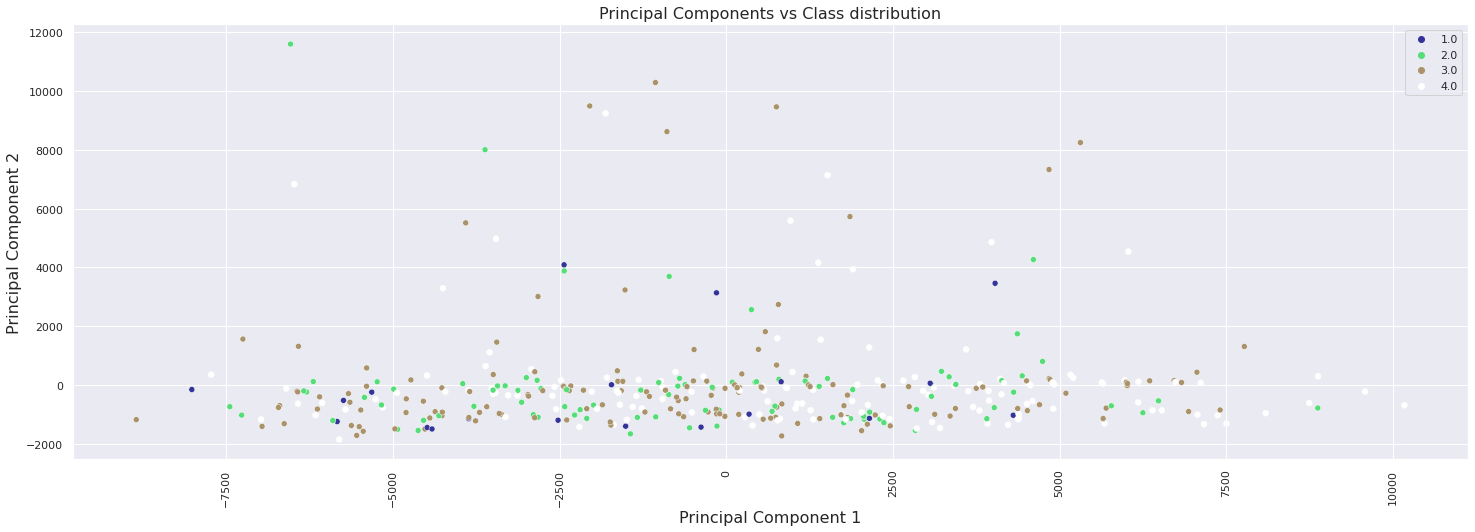

In [39]:
pca = PCA(n_components=3)
pca.fit(cirrhosis_X)
cirrhosis_X_pca = pca.transform(cirrhosis_X)

plt.figure(figsize=(25,8))
sns.scatterplot(x=cirrhosis_X_pca[:,0], y=cirrhosis_X_pca[:, 1], hue=cirrhosis_y, palette='terrain')
plt.title('Principal Components vs Class distribution', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=16)
plt.xticks(rotation='vertical')

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 <a list of 8 Text major ticklabel objects>)

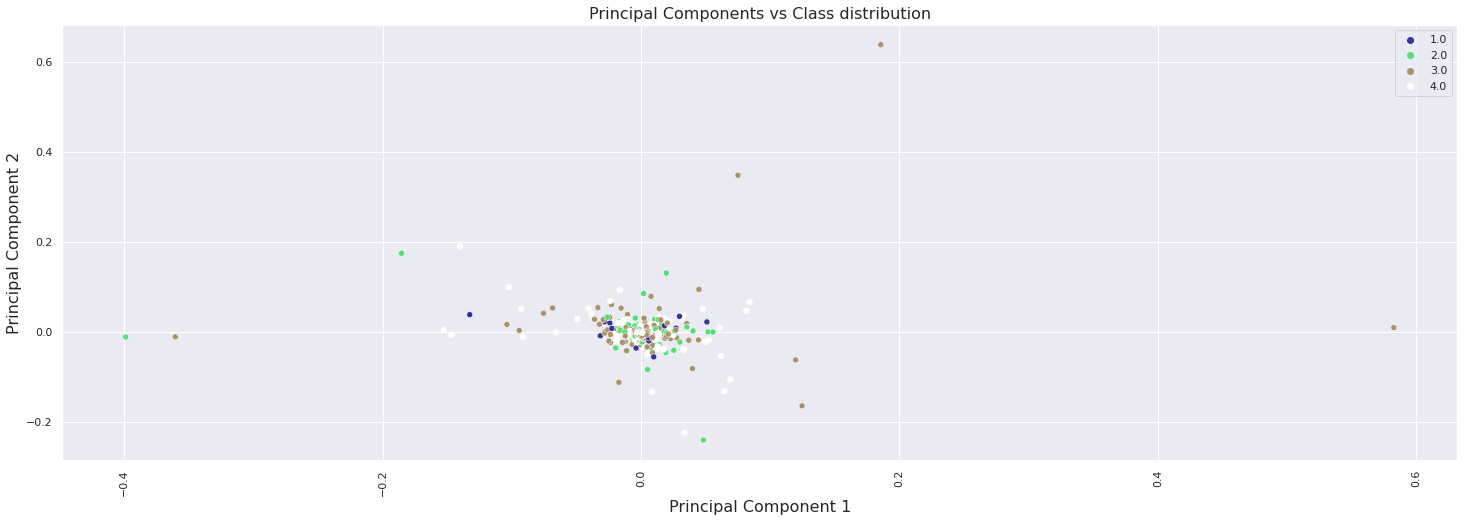

In [40]:
kernel_pca = KernelPCA(
                n_components=2, kernel='rbf', gamma=1, fit_inverse_transform=True, alpha=0.1
            )
kernel_pca.fit(cirrhosis_X)
cirrhosis_X_pca = kernel_pca.transform(cirrhosis_X)

plt.figure(figsize=(25,8))
sns.scatterplot(x=cirrhosis_X_pca[:,0], y=cirrhosis_X_pca[:, 1], hue=cirrhosis_y, palette='terrain')
plt.title('Principal Components vs Class distribution', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=16)
plt.xticks(rotation='vertical')

In [51]:
gamma_list = np.logspace(-5, 5, num=5, base=10)
alpha_list = np.logspace(-5, 2, num=5, base=10)
kernel_list = ['linear', 'rbf', 'cosine']

for gamma in gamma_list:
    for alpha in alpha_list:
        for kernel in kernel_list:    
            kernel_pca = KernelPCA(
                    n_components=2, kernel=kernel, gamma=gamma, fit_inverse_transform=True, alpha=alpha
                )

            kernel_pca.fit(cirrhosis_X)
            cirrhosis_X_kpca = kernel_pca.transform(cirrhosis_X)
            
            fig = plt.figure()
            plt.scatter(cirrhosis_X_kpca[:,0], cirrhosis_X_kpca[:, 1], marker='o', c=cirrhosis_y, s=25, edgecolor='k') 
            plt.title('2-component KPCA on BC with {gamma}, {alpha}, {kernel}'.format(gamma=np.round(gamma,4), alpha=np.round(alpha,4), kernel=kernel))
            plt.xlabel('PC_1')
            plt.ylabel('PC_2')
            plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [56]:
acc_train = []
acc_test = []

for fold, (train_ids, test_ids) in enumerate(kfold.split(cirrhosis_X)):
    X_train, X_test = cirrhosis_X[train_ids], cirrhosis_X[test_ids]
    Y_train, Y_test = cirrhosis_y[train_ids], cirrhosis_y[test_ids]

    pca = PCA(n_components=4)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    clf = svm.SVC(kernel='poly', C=10)
    clf.fit(X_train_pca, Y_train)
    
    print('Train accuracy:', round(clf.score(X_train_pca, Y_train),2))
    print('Test accuracy:', round(clf.score(X_test_pca, Y_test),2))
    
    acc_train.append(clf.score(X_train_pca, Y_train))
    acc_test.append(clf.score(X_test_pca, Y_test))
final_acc_test = round(np.mean(acc_test),2)
final_acc_train = round(np.mean(acc_train),2)

print('Average test accuracy over 5 folds:', final_acc_test)
print('Average train accuracy over 5 folds:', final_acc_train)

Train accuracy: 0.49
Test accuracy: 0.46
Train accuracy: 0.52
Test accuracy: 0.46
Train accuracy: 0.49
Test accuracy: 0.46
Train accuracy: 0.48
Test accuracy: 0.46
Train accuracy: 0.5
Test accuracy: 0.41
Average test accuracy over 5 folds: 0.45
Average train accuracy over 5 folds: 0.5


In [62]:
acc_train = []
acc_test = []

for fold, (train_ids, test_ids) in enumerate(kfold.split(cirrhosis_X)):
    X_train, X_test = cirrhosis_X[train_ids], cirrhosis_X[test_ids]
    Y_train, Y_test = cirrhosis_y[train_ids], cirrhosis_y[test_ids]

    kernel_pca = KernelPCA(n_components=2, kernel='cosine')
    kernel_pca.fit(X_train)
    X_train_pca = kernel_pca.transform(X_train)
    X_test_pca = kernel_pca.transform(X_test)
    
    clf = svm.SVC(kernel='poly', C=10)
    clf.fit(X_train_pca, Y_train)
    
    print('Train accuracy:', round(clf.score(X_train_pca, Y_train),2))
    print('Test accuracy:', round(clf.score(X_test_pca, Y_test),2))
    
    acc_train.append(clf.score(X_train_pca, Y_train))
    acc_test.append(clf.score(X_test_pca, Y_test))
final_acc_test = round(np.mean(acc_test),2)
final_acc_train = round(np.mean(acc_train),2)

print('Average test accuracy over 5 folds:', final_acc_test)
print('Average train accuracy over 5 folds:', final_acc_train)

Train accuracy: 0.46
Test accuracy: 0.49
Train accuracy: 0.47
Test accuracy: 0.41
Train accuracy: 0.47
Test accuracy: 0.45
Train accuracy: 0.45
Test accuracy: 0.49
Train accuracy: 0.45
Test accuracy: 0.4
Average test accuracy over 5 folds: 0.45
Average train accuracy over 5 folds: 0.46


In [70]:
acc_train = []
acc_test = []

for fold, (train_ids, test_ids) in enumerate(kfold.split(cirrhosis_X)):
    X_train, X_test = cirrhosis_X[train_ids], cirrhosis_X[test_ids]
    Y_train, Y_test = cirrhosis_y[train_ids], cirrhosis_y[test_ids]

    lda = LinearDiscriminantAnalysis(n_components=2)
    lda.fit(X_train, Y_train)
    X_lda_train = lda.transform(X_train)
    X_lda_test = lda.transform(X_test)
    
    clf = svm.SVC(kernel='poly', C=10)
    clf.fit(X_lda_train, Y_train)
    
    print('Train accuracy:', round(clf.score(X_lda_train, Y_train),2))
    print('Test accuracy:', round(clf.score(X_lda_test, Y_test),2))
    
    acc_train.append(clf.score(X_lda_train, Y_train))
    acc_test.append(clf.score(X_lda_test, Y_test))
final_acc_test = round(np.mean(acc_test),2)
final_acc_train = round(np.mean(acc_train),2)

print('Average test accuracy over 5 folds:', final_acc_test)
print('Average train accuracy over 5 folds:', final_acc_train)

Train accuracy: 0.53
Test accuracy: 0.51
Train accuracy: 0.5
Test accuracy: 0.49
Train accuracy: 0.52
Test accuracy: 0.45
Train accuracy: 0.51
Test accuracy: 0.5
Train accuracy: 0.5
Test accuracy: 0.46
Average test accuracy over 5 folds: 0.48
Average train accuracy over 5 folds: 0.51


# Logistic Regression with Feature Selection

In [82]:
acc_train = []
acc_test = []

for fold, (train_ids, test_ids) in enumerate(kfold.split(cirrhosis_X)):
    X_train, X_test = cirrhosis_X[train_ids], cirrhosis_X[test_ids]
    Y_train, Y_test = cirrhosis_y[train_ids], cirrhosis_y[test_ids]

    clf = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5)
    clf.fit(X_train, Y_train)
    
    print('Train accuracy:', round(clf.score(X_train, Y_train),2))
    print('Test accuracy:', round(clf.score(X_test, Y_test),2))
    
    acc_train.append(clf.score(X_train, Y_train))
    acc_test.append(clf.score(X_test, Y_test))
final_acc_test = round(np.mean(acc_test),2)
final_acc_train = round(np.mean(acc_train),2)

print('Average test accuracy over 5 folds:', final_acc_test)
print('Average train accuracy over 5 folds:', final_acc_train)

Train accuracy: 0.47
Test accuracy: 0.43
Train accuracy: 0.48
Test accuracy: 0.47
Train accuracy: 0.48
Test accuracy: 0.43
Train accuracy: 0.48
Test accuracy: 0.46
Train accuracy: 0.47
Test accuracy: 0.49
Average test accuracy over 5 folds: 0.46
Average train accuracy over 5 folds: 0.47


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [83]:
# try linear SVC with lasso
# try changing the label encoding
# do boosting